# Imports

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from utils import load_images, plot_confusion_matrix

# Parameters

In [2]:
N_BREEDS = 2
STD_SIZE = (500, 375)

ENVIRONNEMENT = 'local'
if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/Data/'
else:
    PATH = 'images/'

params = {
    'filter': 'None',
    'box_size': 3,  # Used only with mean, gaussian and median filter
    'n_clusters': 75*N_BREEDS,
    'normalization' : False,
}

# Load images

In [3]:
images_orig, y = load_images(PATH, N_BREEDS, STD_SIZE)

Loaded 1/2: 152 images for breed: Chihuahua
Loaded 2/2: 185 images for breed: Japanese_spaniel


# Apply filter

In [113]:
images = np.array(images_orig)
if params['filter'] == 'equalize':
    images = [cv2.equalizeHist(img) for img in images]
if params['filter'] == 'mean':
    images = [cv2.blur(img, (params['box_size'], params['box_size'])) for img in images]
if params['filter'] == 'gaussian':
    images = [cv2.GaussianBlur(img, (params['box_size'], params['box_size']), 0) for img in images]
if params['filter'] == 'median':
    images = [cv2.medianBlur(img, params['box_size']) for img in images]
if params['filter'] == 'non-local':
    images = [cv2.fastNlMeansDenoising(img) for img in images]
if params['filter'] == 'whitening':   
    images = np.array(images_orig)
    images_temp = images.reshape(images.shape[0], -1)
    images_temp = images_temp - images_temp.mean(axis=0)
    cov = np.cov(images_temp, rowvar=True)
    U, S, V = np.linalg.svd(cov)
    epsilon = 1e-1
    images_ZCA = np.dot(np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S + epsilon)), U.T)), images_temp)
    images_ZCA_rescaled = 255 * (images_ZCA - images_ZCA.min()) / (images_ZCA.max() - images_ZCA.min())
    images = images_ZCA_rescaled.reshape(images.shape[0], 375, 500).astype('uint8') 
images = np.array(images)
print(f"Images pre-processed with {params['filter']} filter")

Images pre-processed with None filter


# Train/test split

In [114]:
images_train, images_test, y_train, y_test = train_test_split(images, y, test_size=0.20, stratify=y, random_state=0)

# Extract SIFT features

In [115]:
sift = cv2.xfeatures2d_SIFT.create()
descriptors = []
for image in images_train:
    kp, desc = sift.detectAndCompute(image, None)
    descriptors.extend([x for x in desc])
print(f'{len(descriptors)} SIFT descriptors detected over {images_train.shape[0]} images')

272515 SIFT descriptors detected over 269 images


# KMeans clustering

In [116]:
kmeans = MiniBatchKMeans(n_clusters=params['n_clusters'], batch_size=10000, random_state=0)
kmeans.fit(descriptors)
print(f'KMeans clustering with {params["n_clusters"]} clusters')

KMeans clustering with 150 clusters


# Inputs

In [117]:
X_train = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
X_test = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
for image in images_train:
    kp, desc = sift.detectAndCompute(image, None)
    labels = kmeans.predict(pd.DataFrame(desc))
    unique, counts = np.unique(labels, return_counts=True)
    X_train = X_train.append(dict(zip(unique, counts)), ignore_index=True)
for image in images_test:
    kp, desc = sift.detectAndCompute(image, None)
    labels = kmeans.predict(pd.DataFrame(desc))
    unique, counts = np.unique(labels, return_counts=True)
    X_test = X_test.append(dict(zip(unique, counts)), ignore_index=True)

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [118]:
breed_train = y_train
breed_test = y_test

# Output

In [119]:
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

# Train classifier (CV)

Fitting 4 folds for each of 21 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    5.2s finished


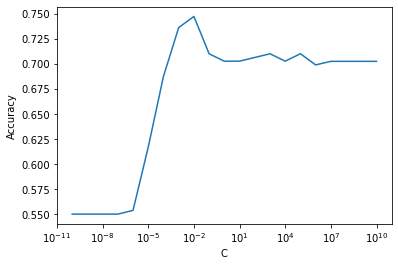

In [120]:
param_grid = {'C': np.logspace(-10, 10, 21)}
model = GridSearchCV(LogisticRegression(max_iter = 1000), param_grid, cv=4, scoring='accuracy', verbose=1)
model.fit(X_train, y_train)

plt.semilogx(model.param_grid['C'], model.cv_results_['mean_test_score'])
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.show()

y_pred = model.predict(X_test)

# Results

## Baseline

----- Accuracy: 76.47 % -----
Filter: None (box size: 3 - only relevant for mean, gaussian and median filters)
Normalization: False
n_clusters: 150


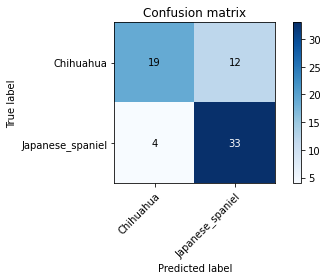

In [14]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'Normalization: {params["normalization"]}')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

## Equalization

----- Accuracy: 75.00 % -----
Filter: equalize (box size: 3 - only relevant for mean, gaussian and median filters)
Normalization: False
n_clusters: 150


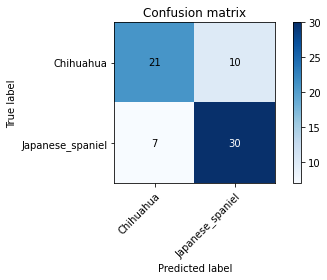

In [32]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'Normalization: {params["normalization"]}')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

## Averaging

----- Accuracy: 69.12 % -----
Filter: mean (box size: 3 - only relevant for mean, gaussian and median filters)
Normalization: False
n_clusters: 150


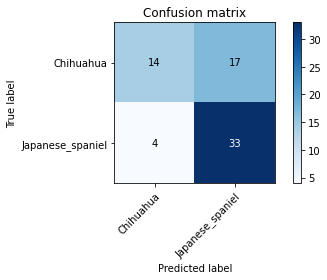

In [44]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'Normalization: {params["normalization"]}')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

## Gaussian filter

----- Accuracy: 67.65 % -----
Filter: gaussian (box size: 3 - only relevant for mean, gaussian and median filters)
Normalization: False
n_clusters: 150


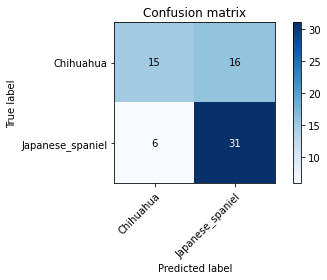

In [55]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'Normalization: {params["normalization"]}')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

## Median filter

----- Accuracy: 67.65 % -----
Filter: median (box size: 3 - only relevant for mean, gaussian and median filters)
Normalization: False
n_clusters: 150


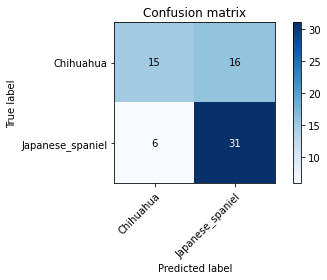

In [65]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'Normalization: {params["normalization"]}')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

## Non-local means filter

----- Accuracy: 69.12 % -----
Filter: non-local (box size: 3 - only relevant for mean, gaussian and median filters)
Normalization: False
n_clusters: 150


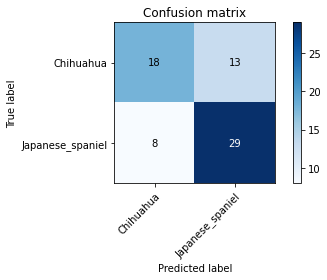

In [75]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'Normalization: {params["normalization"]}')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

## ZCA whitening

----- Accuracy: 67.65 % -----
Filter: whitening (box size: 3 - only relevant for mean, gaussian and median filters)
Normalization: False
n_clusters: 150


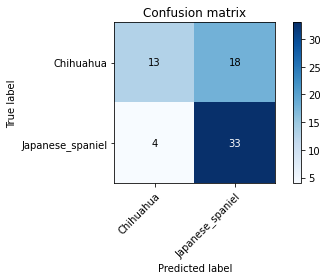

In [85]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'Normalization: {params["normalization"]}')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

## Number of clusters

In [108]:
mean_test_score = dict()
accuracies = dict()
for n_clusters in [10, 20, 50, 100, 125, 150, 175, 200]:
    print(f"Starting to test n_clusters = {n_clusters}")
    params["n_clusters"] = n_clusters
    accuracies[n_clusters] = []
    for i in range(10):
        kmeans = MiniBatchKMeans(n_clusters=params["n_clusters"], batch_size=10000)
        kmeans.fit(descriptors)
        X_train = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
        X_test = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
        for image in images_train:
            kp, desc = sift.detectAndCompute(image, None)
            labels = kmeans.predict(pd.DataFrame(desc))
            unique, counts = np.unique(labels, return_counts=True)
            X_train = X_train.append(dict(zip(unique, counts)), ignore_index=True)
        for image in images_test:
            kp, desc = sift.detectAndCompute(image, None)
            labels = kmeans.predict(pd.DataFrame(desc))
            unique, counts = np.unique(labels, return_counts=True)
            X_test = X_test.append(dict(zip(unique, counts)), ignore_index=True)
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)
        le = LabelEncoder().fit(y_train)
        y_train = le.transform(y_train)
        y_test = le.transform(y_test)
        param_grid = {'C': np.logspace(-10, 10, 21)}
        model = GridSearchCV(LogisticRegression(max_iter = 1000000), param_grid, cv=4, scoring='accuracy', verbose=0)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"Run n°{i+1} - Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}")
        accuracies[n_clusters].append(accuracy_score(y_test, y_pred))
    mean_test_score[n_clusters] = np.mean(accuracies[n_clusters])

Starting to test n_clusters = 10
Run n°1 - Accuracy: 63.24
Run n°2 - Accuracy: 66.18
Run n°3 - Accuracy: 60.29
Run n°4 - Accuracy: 58.82
Run n°5 - Accuracy: 66.18
Run n°6 - Accuracy: 55.88
Run n°7 - Accuracy: 61.76
Run n°8 - Accuracy: 57.35
Run n°9 - Accuracy: 55.88
Run n°10 - Accuracy: 58.82
Starting to test n_clusters = 20
Run n°1 - Accuracy: 64.71
Run n°2 - Accuracy: 60.29
Run n°3 - Accuracy: 70.59
Run n°4 - Accuracy: 55.88
Run n°5 - Accuracy: 61.76
Run n°6 - Accuracy: 60.29
Run n°7 - Accuracy: 63.24
Run n°8 - Accuracy: 66.18
Run n°9 - Accuracy: 67.65
Run n°10 - Accuracy: 66.18
Starting to test n_clusters = 50
Run n°1 - Accuracy: 64.71
Run n°2 - Accuracy: 70.59
Run n°3 - Accuracy: 67.65
Run n°4 - Accuracy: 72.06
Run n°5 - Accuracy: 57.35
Run n°6 - Accuracy: 70.59
Run n°7 - Accuracy: 70.59
Run n°8 - Accuracy: 72.06
Run n°9 - Accuracy: 75.00
Run n°10 - Accuracy: 69.12
Starting to test n_clusters = 100
Run n°1 - Accuracy: 69.12
Run n°2 - Accuracy: 67.65
Run n°3 - Accuracy: 64.71
Run n°

In [109]:
print(accuracies)
print("\n", mean_test_score)

{10: [0.6323529411764706, 0.6617647058823529, 0.6029411764705882, 0.5882352941176471, 0.6617647058823529, 0.5588235294117647, 0.6176470588235294, 0.5735294117647058, 0.5588235294117647, 0.5882352941176471], 20: [0.6470588235294118, 0.6029411764705882, 0.7058823529411765, 0.5588235294117647, 0.6176470588235294, 0.6029411764705882, 0.6323529411764706, 0.6617647058823529, 0.6764705882352942, 0.6617647058823529], 50: [0.6470588235294118, 0.7058823529411765, 0.6764705882352942, 0.7205882352941176, 0.5735294117647058, 0.7058823529411765, 0.7058823529411765, 0.7205882352941176, 0.75, 0.6911764705882353], 100: [0.6911764705882353, 0.6764705882352942, 0.6470588235294118, 0.6911764705882353, 0.7205882352941176, 0.7794117647058824, 0.6764705882352942, 0.7058823529411765, 0.6911764705882353, 0.7058823529411765], 125: [0.75, 0.75, 0.6911764705882353, 0.7352941176470589, 0.7647058823529411, 0.7647058823529411, 0.6911764705882353, 0.7205882352941176, 0.6911764705882353, 0.7352941176470589], 150: [0.6

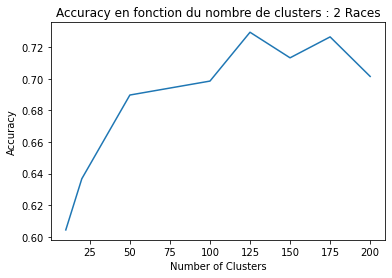

In [110]:
plt.plot(*zip(*sorted(mean_test_score.items())))
plt.ylabel('Accuracy')
plt.xlabel('Number of Clusters')
plt.title('Accuracy en fonction du nombre de clusters : 2 Races')
plt.show()

In [121]:
from sklearn.preprocessing import StandardScaler
scl2 = StandardScaler()
X_scaled = scl2.fit_transform(X_train)


import time

from sklearn.manifold import TSNE



time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_tsne = tsne.fit_transform(X_scaled)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

X_tsne = pd.DataFrame(X_tsne)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 269 samples in 0.008s...
[t-SNE] Computed neighbors for 269 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 269 / 269
[t-SNE] Mean sigma: 2.544496
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.759403
[t-SNE] KL divergence after 300 iterations: 0.595692
t-SNE done! Time elapsed: 0.3729991912841797 seconds


In [122]:
X_tsne.head()

,0,1
0,1.862822,10.600514
1,-3.031960,-4.263834
2,3.194974,-1.242869
3,-0.104191,4.245523
4,-1.750403,-3.036154


(-30.0, 30.0)

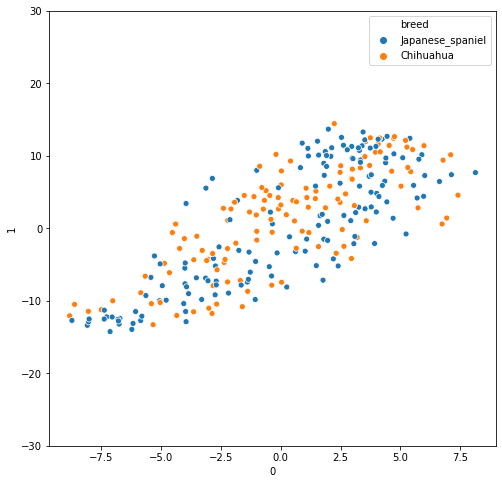

In [123]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

X_tsne['breed'] = breed_train

y_train = ohe.fit_transform(X_tsne[['breed']])

import seaborn as sns

Y = X_tsne

f = plt.figure(figsize=(8, 8))
    
ax = sns.scatterplot(x=0, y=1, hue="breed",data=X_tsne)
ax.set_ylim(-30,30)

[t-SNE] Computing 67 nearest neighbors...
[t-SNE] Indexed 68 samples in 0.000s...
[t-SNE] Computed neighbors for 68 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 68 / 68
[t-SNE] Mean sigma: 6.924213
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.046436
[t-SNE] KL divergence after 300 iterations: 0.910670
t-SNE done! Time elapsed: 0.09199810028076172 seconds


(-30.0, 30.0)

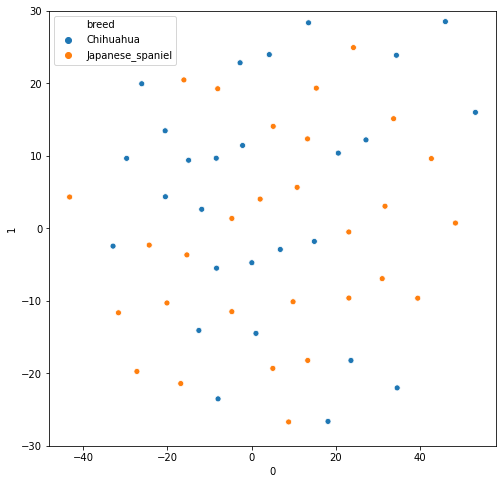

In [124]:
from sklearn.preprocessing import StandardScaler
scl2 = StandardScaler()
X_scaled = scl2.fit_transform(X_test)


import time

from sklearn.manifold import TSNE



time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_tsne = tsne.fit_transform(X_scaled)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

X_tsne = pd.DataFrame(X_tsne)

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

X_tsne['breed'] = breed_test

y_test = ohe.fit_transform(X_tsne[['breed']])

import seaborn as sns

Y = X_tsne

f = plt.figure(figsize=(8, 8))
    
ax = sns.scatterplot(x=0, y=1, hue="breed",data=X_tsne)
ax.set_ylim(-30,30)

In [2]:
accfilters = {'None': 76.47, 'Equalize': 75.00, 'Mean': 69.12, 'Gaussian' : 67.65, 'Median' : 67.65, 'Non-Local Mean' : 69.12, 'ZCA Whitening' : 67.65}

In [3]:
accfilters

{'None': 76.47,
 'Equalize': 75.0,
 'Mean': 69.12,
 'Gaussian': 67.65,
 'Median': 67.65,
 'Non-Local Mean': 69.12,
 'ZCA Whitening': 67.65}

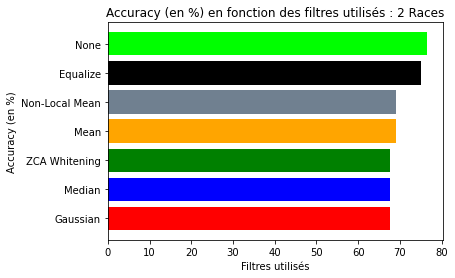

In [7]:
color = ['red','blue','green','orange','slategray','black','lime']
plt.barh(*zip(*sorted(accfilters.items(),key=lambda x: x[1])), color=color)
plt.ylabel('Accuracy (en %)')
plt.xlabel('Filtres utilisés')
plt.title('Accuracy (en %) en fonction des filtres utilisés : 2 Races')
plt.show()